# Generating beautiful HTML components

In this example, we'll build an app that automatically generates HTML components, evaluates them, and captures user feedback. We'll use the feedback and evaluations to build up a dataset
that we'll use as a basis for further improvements.


## The generator

We'll start by using a very simple prompt to generate HTML components using `gpt-3.5-turbo`.


First, we'll initialize an openai client and wrap it with Braintrust's helper. This is a no-op until we start using
the client within code that is instrumented by Braintrust.


In [1]:
import { OpenAI } from "openai";
import { wrapOpenAI } from "braintrust";

const openai = wrapOpenAI(
  new OpenAI({
    apiKey: process.env.OPENAI_API_KEY || "Your OPENAI_API_KEY",
  })
);


This code generates a basic prompt:


In [2]:
import { ChatCompletionMessageParam } from "openai/resources";

function generateMessages(input: string): ChatCompletionMessageParam[] {
  return [
    {
      role: "system",
      content: `You are a skilled design engineer
who can convert ambiguously worded ideas into beautiful, crisp HTML and CSS.
Your designs value simplicity, conciseness, clarity, and functionality over
complexity.

You generate pure HTML with inline CSS, so that your designs can be rendered
directly as plain HTML. Only generate components, not full HTML pages. Do not
create background colors.

Users will send you a description of a design, and you must reply with HTML,
and nothing else. Your reply will be directly copied and rendered into a browser,
so do not include any text. If you would like to explain your reasoning, feel free
to do so in HTML comments.`,
    },
    {
      role: "user",
      content: input,
    },
  ];
}

JSON.stringify(
  generateMessages("A login form for a B2B SaaS product."),
  null,
  2
);


[
  {
    "role": "system",
    "content": "You are a skilled design engineer\nwho can convert ambiguously worded ideas into beautiful, crisp HTML and CSS.\nYour designs value simplicity, conciseness, clarity, and functionality over\ncomplexity.\n\nYou generate pure HTML with inline CSS, so that your designs can be rendered\ndirectly as plain HTML. Only generate components, not full HTML pages. Do not\ncreate background colors.\n\nUsers will send you a description of a design, and you must reply with HTML,\nand nothing else. Your reply will be directly copied and rendered into a browser,\nso do not include any text. If you would like to explain your reasoning, feel free\nto do so in HTML comments."
  },
  {
    "role": "user",
    "content": "A login form for a B2B SaaS product."
  }
]


Now, let's run this using `gpt-3.5-turbo`. We'll also do a few things that help us log & evaluate this function later:

- Wrap the execution in a `traced` call, which will enable Braintrust to log the inputs and outputs of the function when we run it in production or in evals
- Make its signature accept a single `input` value, which Braintrust's `Eval` function expects
- Use a `seed` so that this test is reproduceable


In [4]:
import { traced } from "braintrust";
async function generateComponent(input: string) {
  return traced(
    async (span) => {
      const response = await openai.chat.completions.create({
        model: "gpt-3.5-turbo",
        messages: generateMessages(input),
        seed: 101,
      });
      const output = response.choices[0].message.content;
      span.log({ input, output });
      return output;
    },
    {
      name: "generateComponent",
    }
  );
}


### Examples

Let's look at a few examples!


In [6]:
await generateComponent("Do a reset password form inside a card.");


<div style="display: flex; justify-content: center; align-items: center; height: 100vh;">
  <div style="width: 300px; padding: 20px; border: 1px solid #ccc; border-radius: 5px;">
    <h2 style="text-align: center;">Reset Password</h2>
    <form style="display: flex; flex-direction: column;">
      <label for="email">Email:</label>
      <input type="email" id="email" name="email" placeholder="Enter your email" style="margin-bottom: 10px; padding: 5px;">
      <button type="submit" style="background-color: #4CAF50; color: white; border: none; padding: 10px; border-radius: 5px; cursor: pointer;">Reset Password</button>
    </form>
  </div>
</div>


To make this easier to validate, we'll use [puppeteer](https://pptr.dev/) to render the HTML as a screenshot.


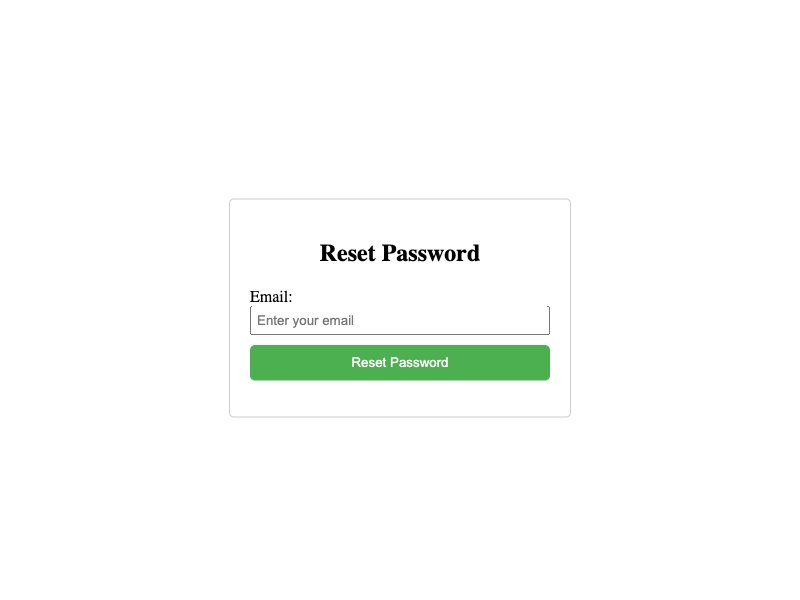

<div style="display: flex; justify-content: center; align-items: center; height: 100vh;">
  <div style="width: 300px; padding: 20px; border: 1px solid #ccc; border-radius: 5px;">
    <h2 style="text-align: center;">Reset Password</h2>
    <form style="display: flex; flex-direction: column;">
      <label for="email">Email:</label>
      <input type="email" id="email" name="email" placeholder="Enter your email" style="margin-bottom: 10px; padding: 5px;">
      <button type="submit" style="background-color: #4CAF50; color: white; border: none; padding: 10px; border-radius: 5px; cursor: pointer;">Reset Password</button>
    </form>
  </div>
</div>


In [11]:
import puppeteer from "puppeteer";
import * as tslab from "tslab";

async function takeFullPageScreenshotAsUInt8Array(htmlContent) {
  const browser = await puppeteer.launch({ headless: "new" });
  const page = await browser.newPage();
  await page.setContent(htmlContent);

  const screenshotBuffer = await page.screenshot();
  const uint8Array = new Uint8Array(screenshotBuffer);

  await browser.close();
  return uint8Array;
}

async function displayComponent(input: string) {
  const html = await generateComponent(input);
  const img = await takeFullPageScreenshotAsUInt8Array(html);
  tslab.display.png(img);
  console.log(html);
}

await displayComponent("Do a reset password form inside a card.");


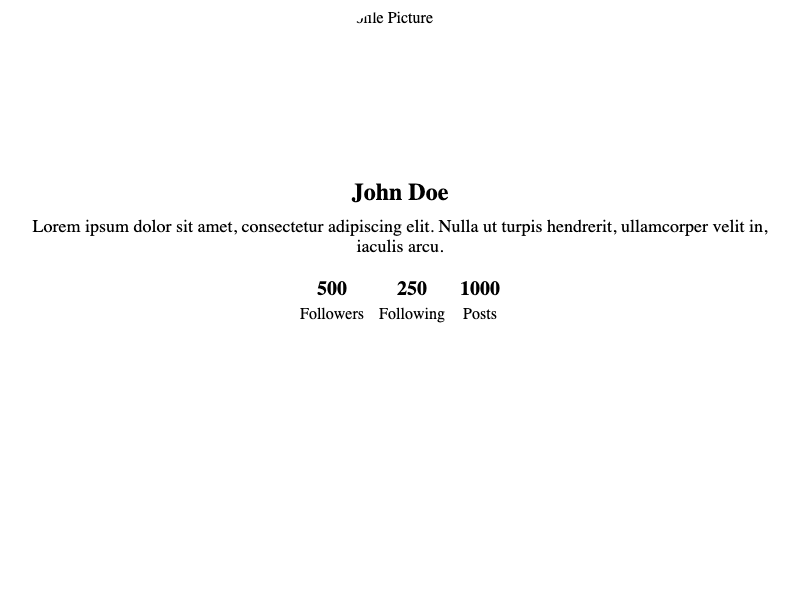

<!DOCTYPE html>
<html>

<head>
    <style>
        .profile {
            display: flex;
            flex-direction: column;
            align-items: center;
        }

        .profile-img {
            width: 150px;
            height: 150px;
            border-radius: 50%;
            margin-bottom: 20px;
        }

        .profile-name {
            font-size: 24px;
            font-weight: bold;
            margin-bottom: 10px;
        }

        .profile-bio {
            font-size: 18px;
            text-align: center;
        }

        .profile-stats {
            display: flex;
            justify-content: space-between;
            width: 200px;
            margin-top: 20px;
        }

        .profile-stats-item {
            display: flex;
            flex-direction: column;
            align-items: center;
        }

        .profile-stats-item-value {
            font-size: 20px;
            font-weight: bold;
            margin-bottom: 5px;
        }

        .profile-

In [8]:
await displayComponent("Create a profile page for a social network.");


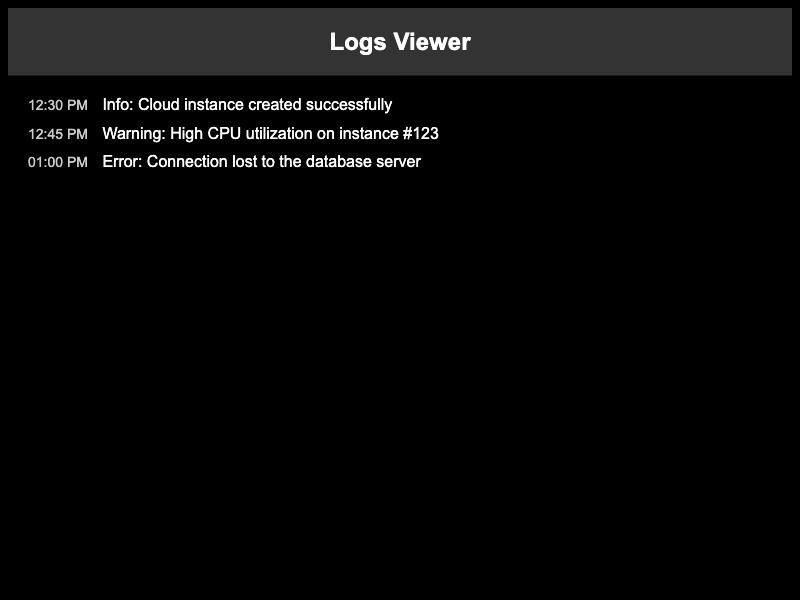

<!DOCTYPE html>
<html>
<head>
<style>
    /* Overall styling */
    body {
        font-family: Arial, sans-serif;
        color: #fff;
        background-color: #000;
    }

    /* Header styling */
    .header {
        background-color: #333;
        padding: 20px;
        text-align: center;
    }

    .header h1 {
        margin: 0;
        font-size: 24px;
    }

    /* Logs viewer styling */
    .logs-viewer {
        padding: 20px;
    }

    .log-entry {
        margin-bottom: 10px;
    }

    .log-entry .timestamp {
        color: #ccc;
        font-size: 14px;
        margin-right: 10px;
    }

    .log-entry .message {
        font-size: 16px;
    }
</style>
</head>
<body>
    <!-- Header -->
    <div class="header">
        <h1>Logs Viewer</h1>
    </div>
    
    <!-- Logs Viewer -->
    <div class="logs-viewer">
        <div class="log-entry">
            <span class="timestamp">12:30 PM</span>
            <span class="message">Info: Cloud instance created successfully</

In [10]:
await displayComponent(
  "Logs viewer for a cloud infrastructure management tool. Heavy use of dark mode."
);


## Scoring the results

It looks like in a few of these examples, the model is generating a full HTML page, instead of a component as we requested. This is something we can evaluate, to ensure that it does not happen!


In [11]:
const containsHTML = (s) => /<(html|body)>/i.test(s);
containsHTML(
  await generateComponent(
    "Logs viewer for a cloud infrastructure management tool. Heavy use of dark mode."
  )
);


true


Now, let's update our function to compute this score. Let's also keep track of requests and their ids, so that we can provide user feedback. Normally you would store these in a database, but for demo purposes, a global dictionary should suffice.


In [12]:
// Normally you would store these in a database, but for this demo we'll just use a global variable.
let requests = {};

async function generateComponent(input: string) {
  return traced(
    async (span) => {
      const response = await openai.chat.completions.create({
        model: "gpt-3.5-turbo",
        messages: generateMessages(input),
        seed: 101,
      });
      const output = response.choices[0].message.content;
      requests[input] = span.id;
      span.log({
        input,
        output,
        scores: { isComponent: containsHTML(output) ? 0 : 1 },
      });
      return output;
    },
    {
      name: "generateComponent",
    }
  );
}


## Logging results

To enable logging to Braintrust, we just need to initialize a logger. By default, a logger is automatically marked as the current, global logger, and once initialized will be picked up by `traced`.


In [13]:
import { initLogger } from "braintrust";

const logger = initLogger({
  projectName: "Component generator",
  apiKey: process.env.BRAINTRUST_API_KEY || "Your BRAINTRUST_API_KEY",
});


Now, we'll run the `generateComponent` function on a few examples, and see what the results look like in Braintrust.


In [13]:
const inputs = [
  "A login form for a B2B SaaS product.",
  "Create a profile page for a social network.",
  "Logs viewer for a cloud infrastructure management tool. Heavy use of dark mode.",
];

for (const input of inputs) {
  await generateComponent(input);
}

console.log(`Logged ${inputs.length} requests to Braintrust.`);


Logged 3 requests to Braintrust.


### Viewing the logs in Braintrust

Once this runs, you should be able to see the raw inputs and outputs, along with their scores in the project.

![component_generator_logs.png](./assets/component-generator-logs.png)


### Capturing user feedback

Let's also track user ratings for these components. Separate from whether or not they're formatted as HTML, it'll be useful to track whether users like the design.

To do this, [configure a new score in the project](https://www.braintrustdata.com/docs/guides/human-review#configuring-human-review). Let's call it "User preference" and make it a 👍/👎.

![Score configuration](./assets/score-config.png)


Once you create a human review score, you can evaluate results directly in the Braintrust UI, or capture end-user feedback. Here, we'll pretend to capture end-user feedback. Personally, I liked the login form and logs viewer, but not the profile page. Let's record feedback accordingly.


In [15]:
// Along with scores, you can optionally log user feedback as comments, for additional color.
logger.logFeedback({
  id: requests["A login form for a B2B SaaS product."],
  scores: { "User preference": 1 },
  comment: "Clean, simple",
});
logger.logFeedback({
  id: requests["Create a profile page for a social network."],
  scores: { "User preference": 0 },
});
logger.logFeedback({
  id: requests[
    "Logs viewer for a cloud infrastructure management tool. Heavy use of dark mode."
  ],
  scores: { "User preference": 1 },
  comment:
    "No frills! Would have been nice to have borders around the entries.",
});


As users provide feedback, you'll see the updates they make in each log entry.


![Feedback log](./assets/feedback-comments.png)


## Creating a dataset

Now that we've collected some interesting examples from users, let's collect them into a dataset, and see if we can improve the `isComponent` score.

In the Braintrust UI, select the examples, and add them to a new dataset called "Interesting cases".

![Interesting cases](./assets/create-new-dataset.png)

Once you create the dataset, it should look something like this:

![Dataset](./assets/dataset.png)

## Evaluating

Now that we have a dataset, let's evaluate the `isComponent` function on it. We'll use the `Eval` function, which takes a dataset and a function, and evaluates the function on each example in the dataset.


In [ ]:
import { Eval, initDataset } from "braintrust";

await Eval("Component generator", {
  data: async () => {
    const dataset = initDataset("Component generator", {
      dataset: "Interesting cases",
    });
    const records = [];
    for await (const { input } of dataset.fetch()) {
      records.push({ input });
    }
    return records;
  },
  task: generateComponent,
  // We do not need to add any additional scores, because our
  // generateComponent() function already computes `isComponent`
  scores: [],
});


Once the eval runs, you'll see a summary which includes a link to the experiment. As expected, only one of the three outputs contains HTML, so the score is 33.3%. Let's also label user preference for this experiment, so we can track aesthetic taste manually. For simplicity's sake, we'll use the same labeling as before.

![Initial experiment](./assets/initial-experiment.png)

### Improving the prompt

Next, let's try to tweak the prompt to stop rendering full HTML pages.


In [17]:
function generateMessages(input: string): ChatCompletionMessageParam[] {
  return [
    {
      role: "system",
      content: `You are a skilled design engineer
who can convert ambiguously worded ideas into beautiful, crisp HTML and CSS.
Your designs value simplicity, conciseness, clarity, and functionality over
complexity.

You generate pure HTML with inline CSS, so that your designs can be rendered
directly as plain HTML. Only generate components, not full HTML pages. If you
need to add CSS, you can use the "style" property of an HTML tag. You cannot use
global CSS in a <style> tag.

Users will send you a description of a design, and you must reply with HTML,
and nothing else. Your reply will be directly copied and rendered into a browser,
so do not include any text. If you would like to explain your reasoning, feel free
to do so in HTML comments.`,
    },
    {
      role: "user",
      content: input,
    },
  ];
}

JSON.stringify(
  generateMessages("A login form for a B2B SaaS product."),
  null,
  2
);


[
  {
    "role": "system",
    "content": "You are a skilled design engineer\nwho can convert ambiguously worded ideas into beautiful, crisp HTML and CSS.\nYour designs value simplicity, conciseness, clarity, and functionality over\ncomplexity.\n\nYou generate pure HTML with inline CSS, so that your designs can be rendered\ndirectly as plain HTML. Only generate components, not full HTML pages. If you\nneed to add CSS, you can use the \"style\" property of an HTML tag. You cannot use\nglobal CSS in a <style> tag.\n\nUsers will send you a description of a design, and you must reply with HTML,\nand nothing else. Your reply will be directly copied and rendered into a browser,\nso do not include any text. If you would like to explain your reasoning, feel free\nto do so in HTML comments."
  },
  {
    "role": "user",
    "content": "A login form for a B2B SaaS product."
  }
]


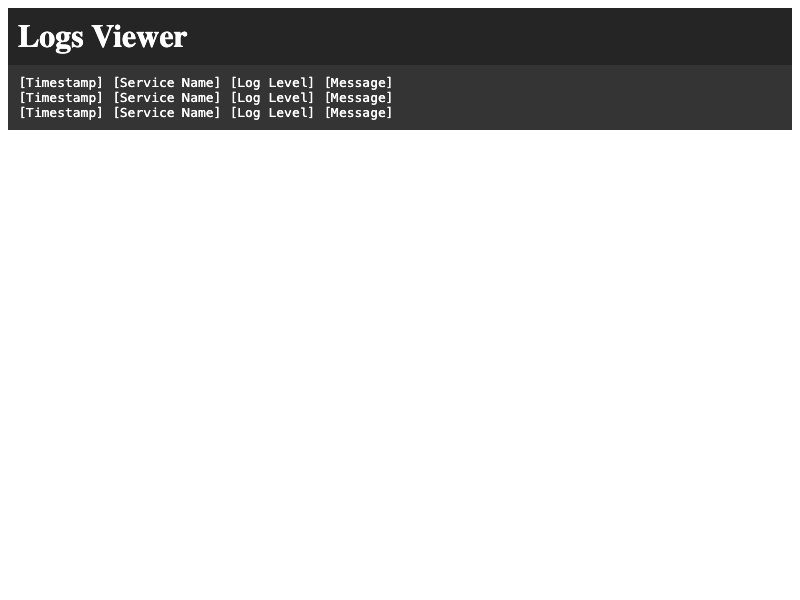



<div>
  <div style="background-color: #252525; color: #FFFFFF; padding: 10px;">
    <h1 style="margin: 0;">Logs Viewer</h1>
  </div>
  <div style="background-color: #343434; color: #FFFFFF; padding: 10px;">
    <pre style="margin: 0;">[Timestamp] [Service Name] [Log Level] [Message]</pre>
    <pre style="margin: 0;">[Timestamp] [Service Name] [Log Level] [Message]</pre>
    <pre style="margin: 0;">[Timestamp] [Service Name] [Log Level] [Message]</pre>
    <!-- Repeat as needed for more logs -->
  </div>
</div>


In [19]:
await displayComponent(
  "Logs viewer for a cloud infrastructure management tool. Heavy use of dark mode."
);


Nice, it looks like it no longer generates an `html` tag. Let's re-run the `Eval` (copy/pasted below for convenience).


In [ ]:
import { Eval, initDataset } from "braintrust";

await Eval("Component generator", {
  data: async () => {
    const dataset = initDataset("Component generator", {
      dataset: "Interesting cases",
    });
    const records = [];
    for await (const { input } of dataset.fetch()) {
      records.push({ input });
    }
    return records;
  },
  task: generateComponent,
  scores: [], // We do not need to add any additional scores, because our generateComponent() function already computes isComponent
});
console.log("Done!");


Nice! We are now generating components without the `<html>` tag.

![Next experiment](./assets/next-experiment.png)


## Where to go from here

Now that we've run another experiment, a good next step would be to rate the new components and make sure we did not suffer a serious aesthetic regression. You can also collect more user examples, add them to the dataset, and re-evaluate to better assess how well your application works. Happy evaluating!
